# Generate Training Data

- Divide the goal up into equally-spaced regions
- Draw a grid around the goal
- Go through this grid and generate a kick that will land exactly there
- Label is `wide-left`, `shot-left`, `shot-center`, `shot-right`, or `wide-right`
- New twist is adding shots which are short. These shots get labels `wide-left-short`, `shot-left-short`, `shot-center-short`, `shot-right-short`, or `wide-right-short`

### 2D Deterministic Data Generator

In [192]:
colormap = np.array(['r', 'b'])

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


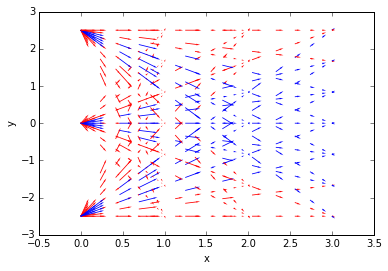

In [193]:
import math
import random

import itertools
from collections import namedtuple

State = namedtuple('State', ['x', 'y', 'dx', 'dy', 'label'])

def data_generator(num_xs_start=2, num_ys_start=2, num_xs_end=2, num_ys_end=2, time_steps=10, decay=.8):
    """Generate data from a fixed set of grid points
    
    Parameters
    ----------
    num_xs_start : int
    The number of starting x points you want
    
    num_ys_start : int
    The number of starting y points you want
    
    num_xs_end : int
    The number of ending points in the x direction you want
    
    num_ys_end : int
    The number of ending points in the y direction you want
    
    time_steps : int
    The number of time steps for the ball to get to the robot. This number should be calculated based on
    the assumption that we're operating at 50 Hz. A reasonable number of time steps would thus be 100 (2 seconds)
    
    decay : float
    The constant decay rate of the velocity of the ball
    
    """    
    # Hard-code a single starting point
    xs_start, ys_start = np.linspace(0, 1, num_xs_start), np.linspace(-2.5, 2.5, num_ys_start)
    starts = itertools.product(xs_start, ys_start)
    
    # Create grid of end points
    xs_end, ys_end = np.linspace(1, 3, num_xs_end), np.linspace(-2.5, 2.5, num_ys_end)
    ends = itertools.product(xs_end, ys_end)
    
    for (x_start, y_start), (x_end, y_end) in itertools.product(starts, ends):
        if x_end < 2:
            label = 0
        else:
            # Draw a line and see where the ball intersects
            slope = (y_end-y_start) / (x_end-x_start)
            y = slope*(2-x_start) + y_start
            label = 1 if -1.5 <= y <= 1.5 else 0

        # Starting velocities to reach the destination
        c = (1-decay) / (1-decay**(time_steps-1))
        dx_start = c * (x_end-x_start)
        dy_start = c * (y_end-y_start)

        # Calculate how far you've traveled from the start at each time_step
        decays = np.array([decay**pow for pow in range(time_steps)])

        # Velocity at each time step
        x_velocities = decays * dx_start
        y_velocities = decays * dy_start

        # Distance traveled at each time step
        x_deltas = np.cumsum(x_velocities)
        y_deltas = np.cumsum(y_velocities)

        # Compute the actual points given deltas
        x_positions = x_start + x_deltas
        x_positions = np.append([x_start], x_positions[:-1])
        y_positions = y_start + y_deltas
        y_positions = np.append([y_start], y_positions[:-1])
        
        # Yield the points one by one
        for x, y, dx, dy in zip(x_positions, y_positions, x_velocities, y_velocities):
            yield State(x, y, dx, dy, label)


data_points = data_generator(num_xs_start=1, num_ys_start=3, num_xs_end=3, num_ys_end=7)
data_points = list(data_points)
labels = np.array([data_point.label for data_point in data_points])

df = pd.DataFrame(data_points, columns=State._fields)
axes = df.plot(kind='scatter', x='x', y='y', c=colormap[labels], s=0)
axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

### Class Numbers

In [194]:
df.groupby('label').size()

label
0    390
1    240
dtype: int64

### Filter Away Points out of Goalie's Field of View

label
0    354
1    150
dtype: int64

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


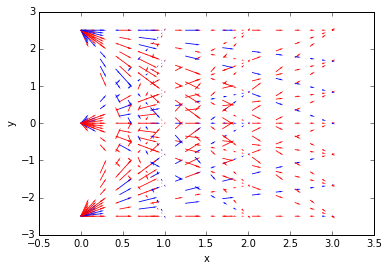

In [195]:
data_points = [data_point for data_point in data_points if not data_point.x > 2]

data_points_2d = pd.DataFrame(data_points, columns=State._fields)

# Plot it
labels = data_points_2d['label']
axes = data_points_2d.plot(kind='scatter', x='x', y='y', c=colormap[labels], s=0)
axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)
 
data_points_2d.groupby('label').size()

### Restore Class Balance

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


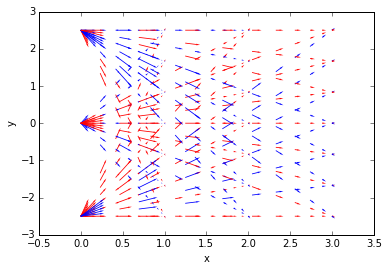

In [196]:
groups = data_points_2d.groupby('label')
max_size = groups.size().min()

def filter_down(group):
    """Filters down a pandas groupby object to a specified number"""
    
    size = len(group)
    mask = np.full(size, False, bool)
    lucky_indices = np.random.choice(size, max_size, replace=False)
    mask[lucky_indices] = True
    
    return group[mask]

many_many_short = groups.apply(filter_down)

# Plot it
labels = many_many_short['label']
axes = many_many_short.plot(kind='scatter', x='x', y='y', c=colormap[labels], s=0)
axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

In [197]:
many_many_short.groupby('label').size()

label
0    150
1    150
dtype: int64

In [198]:
%store many_many_short

Stored 'many_many_short' (DataFrame)
